In [1]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"

In [2]:
#@title Settings for your newly created concept
#@markdown `what_to_teach`: what is it that you are teaching? `object` enables you to teach the model a new object to be used, `style` allows you to teach the model a new style one can use.
what_to_teach = "object" #@param ["object", "style"]
#@markdown `placeholder_token` is the token you are going to use to represent your new concept (so when you prompt the model, you will say "A `<my-placeholder-token>` in an amusement park"). We use angle brackets to differentiate a token from other words/tokens, to avoid collision.
placeholder_token1 = "<shape>" #@param {type:"string"}
#@markdown `initializer_token` is a word that can summarise what your new concept is, to be used as a starting point
initializer_token1 = "shape" #@param {type:"string"}

#@title Setup the prompt templates for training 
#@title Setup the prompt templates for training 
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of a {}",
    "the photo of a {}",
    "a photo of clean a {}",
    "a photo of dirty a {}",
    "a dark photo of a {}",
    "a photo of a {}",
    "a close-up photo of a {}",
    "a bright photo of a {}",
    "a good photo of a {}",
    "a photo of one a {}",
    "a close-up photo of a {}",
    "a rendition of a {}",
    "a photo of nice a {}",
    "a good photo of a {}",
    "a photo of a weird {}",
    "a photo of a large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

In [3]:
#@title Load the tokenizer and add the placeholder token as a additional special token.
#@markdown Please read and if you agree accept the LICENSE [here](https://huggingface.co/CompVis/stable-diffusion-v1-4) if you see an error
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token1)
if num_added_tokens < 1:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token1}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )
    
token_ids1 = tokenizer.encode(initializer_token1, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids1) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id1 = token_ids1[0]
placeholder_token_id1 = tokenizer.convert_tokens_to_ids(placeholder_token1)


#@title Load the Stable Diffusion model
# Load models and create wrapper for stable diffusion
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)
text_encoder.resize_token_embeddings(len(tokenizer))
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id1] = token_embeds[initializer_token_id1]

In [4]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000, tensor_format="pt"
)

hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 3000,
    "train_batch_size": 1,
    "gradient_accumulation_steps": 4,
    "seed": 42,
    "output_dir": "decomposed-ball-concept"
}

In [8]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        im = img.resize((w//4, h//4))
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

  0%|          | 0/51 [00:00<?, ?it/s]

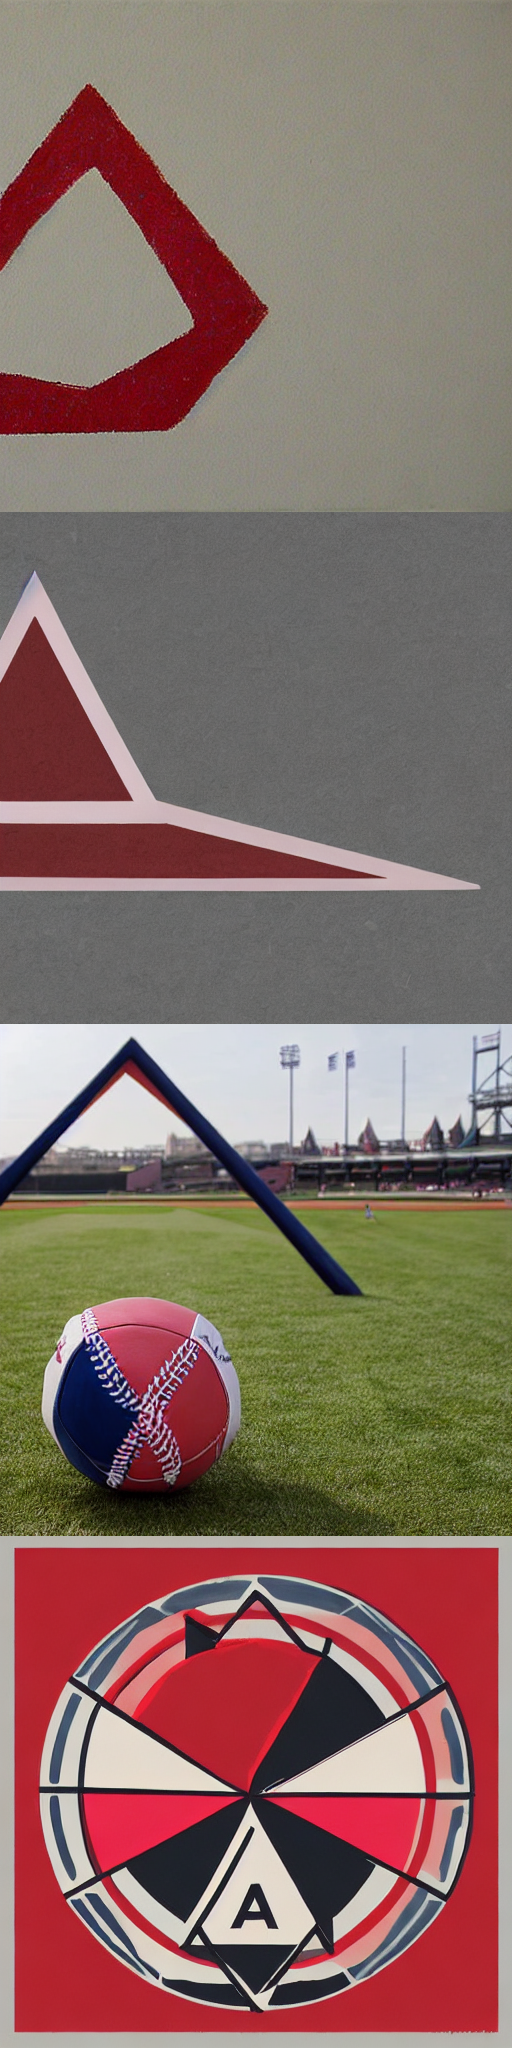

In [10]:
#@title Set up the pipeline 
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    torch_dtype=torch.float16,
).to("cuda")

prompt = "a triangle with the color {}".format(placeholder_token1) #@param {type:"string"}

num_samples = 4 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
#save grid as an image
grid.save("grid.png")
grid

In [23]:
print('Cosine Distance')
print()
import torch.nn.functional as F
import torch.nn as nn
embeddings = pipe.text_encoder.get_input_embeddings().weight
token_id = pipe.tokenizer.convert_tokens_to_ids(placeholder_token1)
cos = nn.CosineSimilarity(dim=1, eps=1e-3)
output = cos(embeddings[token_id].unsqueeze(dim = 0), embeddings)
val, idx = torch.topk(output, k = 10)
print(val)
print(idx)
for i, index in enumerate(idx):
    print(val[i].item(), pipe.tokenizer.decode([index]))

print()
print()
print()
print('Euclidean Distance')
print()
import torch.nn.functional as F
import torch.nn as nn
embeddings = pipe.text_encoder.get_input_embeddings().weight
token_id = pipe.tokenizer.convert_tokens_to_ids(placeholder_token1)
output = -torch.cdist(embeddings[token_id].unsqueeze(dim = 0), embeddings)
val, idx = torch.topk(output, k = 10)
print(val)
print(idx)
for i, index in enumerate(idx[0]):
    print(val[0][i].item(), pipe.tokenizer.decode([index]))


Cosine Distance

tensor([1.0000, 0.1693, 0.1588, 0.1556, 0.1539, 0.1521, 0.1500, 0.1499, 0.1497,
        0.1494], device='cuda:0', dtype=torch.float16, grad_fn=<TopkBackward0>)
tensor([49408, 36845, 33627, 20529, 43733, 29239, 38952, 15297, 35870, 11267],
       device='cuda:0')
1.0 <shape>
0.1693115234375 📍:
0.1588134765625 criteri
0.1556396484375 msc
0.1539306640625 regression
0.152099609375 springwatch
0.1500244140625 ========
0.14990234375 outreach
0.149658203125 wareness
0.1494140625 🎄



Euclidean Distance

tensor([[-0.0000, -2.7930, -2.7949, -2.7949, -2.7969, -2.7988, -2.7988, -2.7988,
         -2.7988, -2.7988]], device='cuda:0', dtype=torch.float16,
       grad_fn=<TopkBackward0>)
tensor([[49408, 36845, 33627, 20529, 43733, 35870, 38952, 29239, 11267, 15297]],
       device='cuda:0')
-0.0 <shape>
-2.79296875 📍:
-2.794921875 criteri
-2.794921875 msc
-2.796875 regression
-2.798828125 wareness
-2.798828125 ========
-2.798828125 springwatch
-2.798828125 🎄
-2.798828125 outreach


In [11]:
from scipy import spatial
token_id = pipe.tokenizer.convert_tokens_to_ids(placeholder_token)
token_embeds = text_encoder.get_input_embeddings().weight.data.cpu()
color_to_attribute_idx = {'blue': 0,'brown': 1,'iridescent': 2,
                                'purple': 3,'rufous': 4,'grey': 5,
                                'yellow': 6,'olive': 7,'green': 8,
                                'pink': 9,'orange': 10,'black': 11,
                                'white':12 ,'red': 13,'buff': 14}
cosine_sims = []
for i in color_to_attribute_idx:
    new_idx = pipe.tokenizer.convert_tokens_to_ids(i)
    cosine_sim = 1 - spatial.distance.cosine(token_embeds[token_id], token_embeds[new_idx])
    cosine_sims.append([i, cosine_sim])
cosine_sims

[['blue', -0.016612088307738304],
 ['brown', 0.021827993914484978],
 ['iridescent', 0.04960748180747032],
 ['purple', 0.015421131625771523],
 ['rufous', 0.04960748180747032],
 ['grey', 0.006637181155383587],
 ['yellow', -0.0013554865727201104],
 ['olive', 0.01335769984871149],
 ['green', -0.03427588939666748],
 ['pink', -0.0004268811026122421],
 ['orange', 0.03001478873193264],
 ['black', 0.02245166525244713],
 ['white', 0.00278395670466125],
 ['red', 0.018257858231663704],
 ['buff', -0.06917596608400345]]

In [12]:
from scipy import spatial
token_id = pipe.tokenizer.convert_tokens_to_ids(placeholder_token)
token_embeds = text_encoder.get_input_embeddings().weight.data.cpu()
color_to_attribute_idx = {'blue': 0,'brown': 1,'iridescent': 2,
                                'purple': 3,'rufous': 4,'grey': 5,
                                'yellow': 6,'olive': 7,'green': 8,
                                'pink': 9,'orange': 10,'black': 11,
                                'white':12 ,'red': 13,'buff': 14}
euclidean_distances = []
for i in color_to_attribute_idx:
    new_idx = pipe.tokenizer.convert_tokens_to_ids(i)
    euclidean_distance = spatial.distance.euclidean(token_embeds[token_id], token_embeds[new_idx])
    euclidean_distances.append([i, euclidean_distance])
euclidean_distances

[['blue', 0.5581141710281372],
 ['brown', 0.5497653484344482],
 ['iridescent', 1.1448577642440796],
 ['purple', 0.5498030781745911],
 ['rufous', 1.1448577642440796],
 ['grey', 0.5555132627487183],
 ['yellow', 0.5641696453094482],
 ['olive', 0.5344266891479492],
 ['green', 0.5556091070175171],
 ['pink', 0.5459226369857788],
 ['orange', 0.5399313569068909],
 ['black', 0.5415103435516357],
 ['white', 0.5550603866577148],
 ['red', 0.5358379483222961],
 ['buff', 0.5831795334815979]]